<a href="https://colab.research.google.com/github/saribasmetehan/CountVectorizer/blob/main/BERT_BankingClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kütüphanelerin yüklenmesi

In [ ]:
!pip install transformers[torch] -U -q
!pip install accelerate -U -q
!pip install -q datasets
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer
import evaluate
from huggingface_hub import notebook_login
from transformers import TrainingArguments

# Veri Setinin yüklenmesi
- *Temel gözlem*

In [ ]:
dataset = load_dataset("legacy-datasets/banking77")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [ ]:
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [ ]:
train_df.nunique().sort_values(ascending = False)

,0
text,10003
label,77


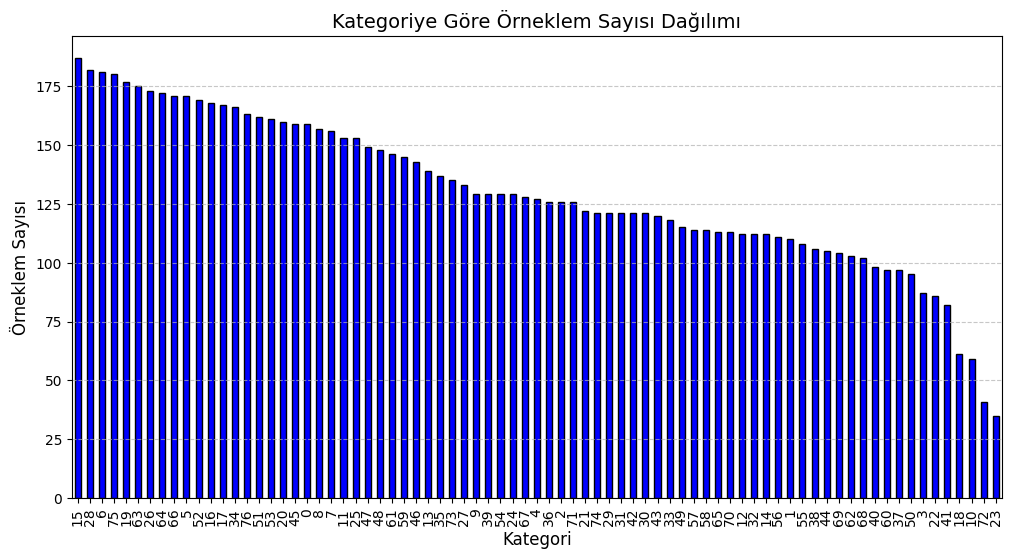

In [ ]:
plt.figure(figsize=(12, 6))
train_df["label"].value_counts().plot(kind='bar', color='blue', edgecolor='black')

plt.title("Kategoriye Göre Örneklem Sayısı Dağılımı", fontsize=14)
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Örneklem Sayısı", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

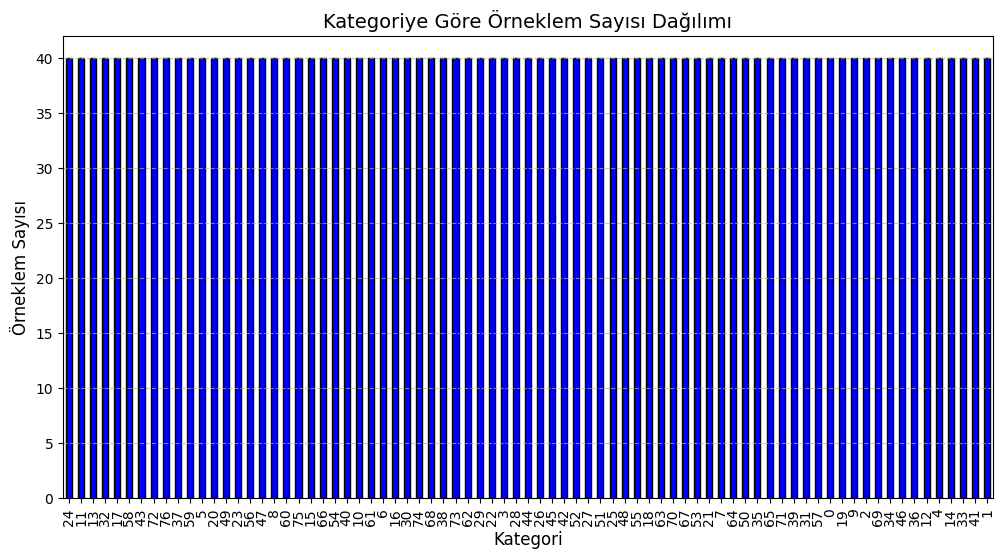

In [ ]:
plt.figure(figsize=(12, 6))
test_df["label"].value_counts().plot(kind='bar', color='blue', edgecolor='black')

plt.title("Kategoriye Göre Örneklem Sayısı Dağılımı", fontsize=14)
plt.xlabel("Kategori", fontsize=12)
plt.ylabel("Örneklem Sayısı", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tokenizer

In [ ]:
model_name = "google-bert/bert-base-uncased"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], truncation = True)

In [ ]:
tokenize(dataset["train"][:3])

{'input_ids': [[101, 1045, 2572, 2145, 3403, 2006, 2026, 4003, 1029, 102], [101, 2054, 2064, 1045, 2079, 2065, 2026, 4003, 2145, 8440, 1005, 1056, 3369, 2044, 1016, 3134, 1029, 102], [101, 1045, 2031, 2042, 3403, 2058, 1037, 2733, 1012, 2003, 1996, 4003, 2145, 2746, 1029, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

# Encoding

In [ ]:
dataset_encoded = dataset.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

# Padding

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

*Cuda aktivasyonu*

In [ ]:
num_labels = 77

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classification Çağırımı

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*Eğitim Metriği*

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)
  return accuracy.compute(predictions = predictions, references = labels)

# Training Argümanları

In [ ]:
training_args = TrainingArguments(output_dir = "BERT-BankingClassifier",
                                   num_train_epochs = 4,
                                   per_device_train_batch_size = 16,
                                   per_device_eval_batch_size = 16,
                                   weight_decay = 0.01,
                                   eval_strategy = "epoch",
                                   save_strategy="epoch",
                                   load_best_model_at_end = True,
                                   report_to = "none",
                                   learning_rate=5e-5,
                                   push_to_hub = True
                                   )

*Encod edilmiş verileri %90-%10 şeklinde düzenleme*

In [ ]:
train_dataset = dataset_encoded["train"]
eval_dataset = dataset_encoded["test"]

shuffled_eval_dataset = dataset_encoded["test"].shuffle(seed=42)
random_train_data = shuffled_eval_dataset.select(range(1700))
remaining_eval_data = shuffled_eval_dataset.select(range(1700, len(shuffled_eval_dataset)))

train_dataset = concatenate_datasets([dataset_encoded["train"], random_train_data])
eval_dataset = remaining_eval_data

In [ ]:
notebook_login()

# Train Çerçevesi

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    tokenizer = tokenizer,
)

<ipython-input-26-72fdbfd26d85>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Eğitim

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,2.536800,0.594478,0.886232
2,0.601300,0.315621,0.928261
3,0.150700,0.289492,0.928986
4,0.089000,0.286654,0.932609


TrainOutput(global_step=2928, training_loss=0.6376082376052773, metrics={'train_runtime': 156.1872, 'train_samples_per_second': 299.717, 'train_steps_per_second': 18.747, 'total_flos': 947345001688860.0, 'train_loss': 0.6376082376052773, 'epoch': 4.0})

# Hugginface'e yüklemek.

In [ ]:
trainer.push_to_hub(commit_message=" Ok! ")

CommitInfo(commit_url='https://huggingface.co/saribasmetehan/BERT-BankingClassifier/commit/e9982c00b7309c0003ddf891a7e8d1f423754286', commit_message=' Ok! ', commit_description='', oid='e9982c00b7309c0003ddf891a7e8d1f423754286', pr_url=None, repo_url=RepoUrl('https://huggingface.co/saribasmetehan/BERT-BankingClassifier', endpoint='https://huggingface.co', repo_type='model', repo_id='saribasmetehan/BERT-BankingClassifier'), pr_revision=None, pr_num=None)